In [3]:
import yaml
from gensim.models import Word2Vec
import pandas as pd
import torch
import os

from net_architectures.mlp import *
from dataset_class import *
from torch.utils.data import DataLoader

In [ ]:
def load_model_from_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss


In [ ]:
df_test = pd.read_csv('dataset/test_df.csv')
df_test = df_test.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

word_to_vec_model = Word2Vec.load("card2vec.model")

fi = open('config.yaml', 'r')
card_dict = yaml.load(fi, Loader=yaml.FullLoader)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path = 'checkpoints/model_4_checkpoint_epoch_20.pt'

model = FeedForwardModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

model, _, _, _ = load_model_from_checkpoint(model, optimizer, checkpoint_path)
model.to(device)
model.eval()

In [ ]:
dataset_test = MagicDataset(df_test, word_to_vec_model, card_dict)
test_loader = DataLoader(dataset_test, batch_size=45, shuffle=False)


accuracy_per_round = np.zeros(45)


total_samples = 0
correct_samples = 0

with torch.no_grad():
    for i, (inputs, labels, mascara) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        mascara = mascara.to(device)
        
        outputs = model(inputs, mascara)
        _, predicted = torch.max(outputs, 1)
        

        total_samples += labels.size(0)
        correct_samples += (predicted == labels).sum().item()


        for j in range(len(inputs)):
            if predicted[j].item() == labels[j].item():
                accuracy_per_round[j] += 1

        if i % 10000 == 0:
            print(f"Batch [{i+1}/{len(test_loader)}] - Accuracy: {100 * correct_samples / total_samples:.2f}%")


print(f"Total Accuracy: {100 * correct_samples / total_samples:.2f}%")

accuracy_per_round = accuracy_per_round/(len(df_test)/45)

Batch [1/21590] - Accuracy: 51.11%
Batch [10001/21590] - Accuracy: 64.23%
Batch [20001/21590] - Accuracy: 64.26%
Total Accuracy: 64.26%


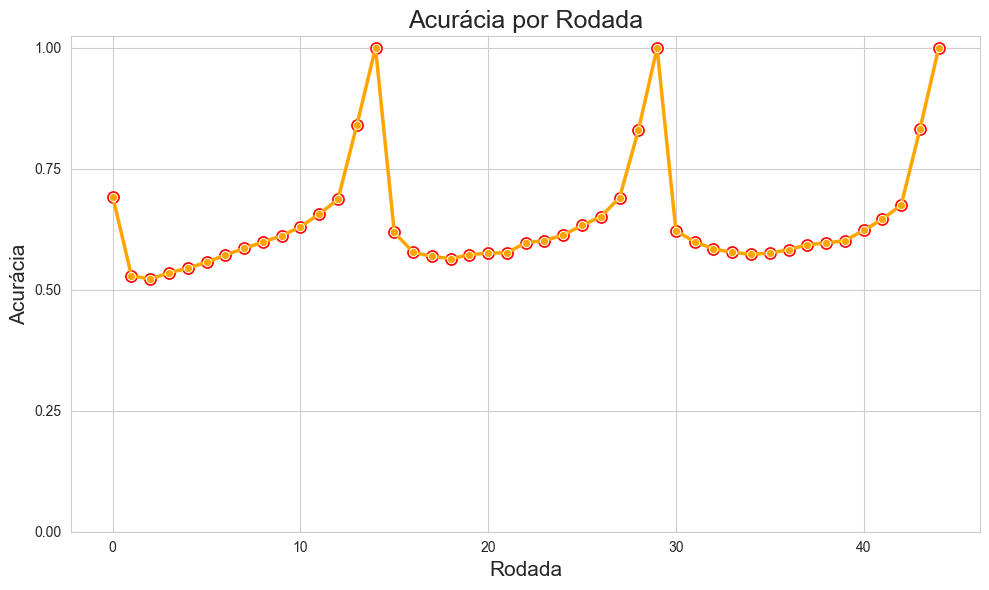

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))

sns.lineplot(x=np.arange(len(accuracy_per_round)), y=accuracy_per_round, linewidth=2.5, color='orange', marker='o')
sns.scatterplot(x=np.arange(len(accuracy_per_round)), y=accuracy_per_round, color='red', s=100)  # s define o tamanho dos pontos

plt.title('Acurácia por Rodada', fontsize=18)
plt.xlabel('Rodada', fontsize=15)
plt.ylabel('Acurácia', fontsize=15)


plt.yticks([0, 0.25, 0.50, 0.75, 1])

plt.tight_layout()

plt.show()
